In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import os
import PIL
import PIL.Image
import sys
import glob
from pathlib import Path


# Get the path of the dataset
os.chdir(sys.path[0])
working_directory = os.getcwd()
print(working_directory)
data_path = Path(working_directory + r"/dataset/IMG_CLASSES")

# Count the number of images within the  dataset
image_count = len(list(data_path.glob('*/*.jpg')))
print("The number of images in the dataset is " + str(image_count))

# Batch size and dimensions
batch_size = 30
IMG_SIZE = (200,200)

#Assigning the data splits and seed
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

c:\Users\Uzair\Desktop\CS Notes\Year 3\Semester 2\Visual Image Processing\Real Project
The number of images in the dataset is 27153
Found 27153 files belonging to 10 classes.
Using 21723 files for training.
Found 27153 files belonging to 10 classes.
Using 5430 files for validation.


In [2]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
])

In [3]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [6]:
IMG_SIZE = (200,200)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.vgg19.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=10
                                              )

#freeze all the layer
for layer in base_model.layers:
    layer.trainable = False

In [7]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [8]:
inputs = tf.keras.Input(shape=(200,200, 3))

x = preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)

# Flatten the output layer to 1 dimension
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x) 
x = layers.Dense(512, activation ='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(10, activation='softmax')(x)

# Configure and compile the model

model = keras.Model(inputs, predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [9]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset,
                    batch_size = 64
                   )

Epoch 1/5
725/725 [==============================] - 158s 200ms/step - loss: 1.6462 - accuracy: 0.4769 - val_loss: 1.0554 - val_accuracy: 0.6083
Epoch 2/5
725/725 [==============================] - 124s 171ms/step - loss: 1.2679 - accuracy: 0.5332 - val_loss: 1.0253 - val_accuracy: 0.6101
Epoch 3/5
725/725 [==============================] - 95s 130ms/step - loss: 1.2017 - accuracy: 0.5496 - val_loss: 0.9765 - val_accuracy: 0.6256
Epoch 4/5
725/725 [==============================] - 128s 176ms/step - loss: 1.1772 - accuracy: 0.5591 - val_loss: 0.9622 - val_accuracy: 0.6389
Epoch 5/5
725/725 [==============================] - 109s 150ms/step - loss: 1.1633 - accuracy: 0.5595 - val_loss: 0.9684 - val_accuracy: 0.6304


In [10]:
for layer in base_model.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

    
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [11]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 200, 200, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 200, 200, 3)      0         
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [13]:
history_unfreeze = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks = [learning_rate_reduction]
)

Epoch 1/30
725/725 [==============================] - 301s 408ms/step - loss: 1.3056 - accuracy: 0.5072 - val_loss: 1.1974 - val_accuracy: 0.5427 - lr: 1.0000e-04
Epoch 2/30
725/725 [==============================] - 226s 311ms/step - loss: 1.0903 - accuracy: 0.5764 - val_loss: 1.1033 - val_accuracy: 0.5575 - lr: 1.0000e-04
Epoch 3/30
725/725 [==============================] - 235s 324ms/step - loss: 0.9855 - accuracy: 0.6195 - val_loss: 0.9620 - val_accuracy: 0.6177 - lr: 1.0000e-04
Epoch 4/30
725/725 [==============================] - 205s 283ms/step - loss: 0.9364 - accuracy: 0.6424 - val_loss: 0.9657 - val_accuracy: 0.6337 - lr: 1.0000e-04
Epoch 5/30
725/725 [==============================] - 311s 429ms/step - loss: 0.8879 - accuracy: 0.6584 - val_loss: 0.8778 - val_accuracy: 0.6431 - lr: 1.0000e-04
Epoch 6/30
725/725 [==============================] - 208s 287ms/step - loss: 0.8709 - accuracy: 0.6606 - val_loss: 1.0402 - val_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 7/30
725/725 [==

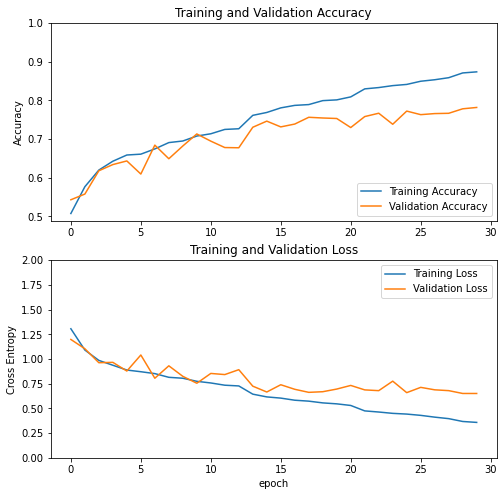

In [16]:
acc = history_unfreeze.history['accuracy']
val_acc = history_unfreeze.history['val_accuracy']

loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('vgg19 score.png')
plt.show()

model.save("vgg19.h5")

In [17]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_unfreeze.history) 

# save to json:  
hist_json_file = 'vgg19_finetune_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
hist_csv_file = 'vgg19_finetune_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)